# Data Cleansing

As a reminder, the dataset contains the entirity of the AskReddit comments in May 2016

In this first notebook, we discover the data and the network structure.

We first import the data and librairies needed. Then, we do some data cleaning. Finally, we try to extract interesting network features from our dataset.

## Set-up


In [1]:
import pickle
import numpy as np
import pandas as pd

Input your repository file here:

In [3]:
repsource = "C:/Users/s1027177/OneDrive - Syngenta/Documents/FOAD/au_secours/"

In [4]:
file = "comments_students.csv"
df = pd.read_csv(repsource+file)

We drop the unneeded variables:

In [5]:
df = df.drop(["subreddit_id","subreddit"], axis=1)
df.head()

,created_utc,ups,link_id,name,id,author,body,parent_id
0,1430438400,3.0,t3_34f9rh,t1_cqug90j,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr
1,1430438400,3.0,t3_34fvry,t1_cqug90k,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry
2,1430438400,5.0,t3_34ffo5,t1_cqug90z,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb
3,1430438401,1.0,t3_34aqsn,t1_cqug91c,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m
4,1430438401,101.0,t3_34f9rh,t1_cqug91e,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc


Check for missing values

In [6]:
print('Is there any missing values?', df.isnull().values.any())
df.isnull().sum()

Is there any missing values? True


created_utc          0
ups            1016458
link_id              0
name                 0
id                   0
author               0
body                61
parent_id            0
dtype: int64

It is not surprising to find maybe missing values in `ups`. It indicates the rows corresponding to the test set.
However, we will have to deal with the missing values in `body` in the text preprocessing part.

### Test and train data separation

Test data is when obsersation for variable ups is lacking.

Train data is size 3 218 512 and test data is size 1 016 458.

In [7]:
def test_split(dataset):
    Test_DF = dataset[pd.isna(dataset.ups)]
    return Test_DF

def train_split(dataset):
    Train_DF = dataset[pd.isna(dataset.ups) == False]
    return Train_DF

## Data cleansing

To evaluate the effect of variables on the score, we separate the data into two subgroups: 


*   Popular comments (=1): more than 2 upvotes (3rd quantile, 22.5% train sample)
*   Average comments (=0): less or equal to 2 upvotes (77.5% train sample).

For the NA (test sample), we put 99 for now.



In [8]:
df["popularity"] = np.where(df.ups > 2, 1, np.where(df.ups.isna(),99,0))
df["popularity"].value_counts()/len(df.ups)*100

0     58.867359
99    24.001540
1     17.131101
Name: popularity, dtype: float64

### First look at the variables

**UPS**

UPS: variable to be predicted. The score of the comment = number of positive votes

Quite a strange distribution, very long tailed at right(for high values) but also small left tail

In [ ]:
pd.value_counts(df.ups[(df.ups < 10)&(df.ups > -5)]).plot(kind='bar')

**created_utc**

The time of creation in UTC epoch-second format. Note that neither of these ever have a non-zero fraction.

In [9]:
df["created_utc"] = pd.to_datetime(df.created_utc,unit='s')

In [10]:
df['day'] = df["created_utc"].dt.day

The following graph is a bar plot of comments posted per day of May 2015:

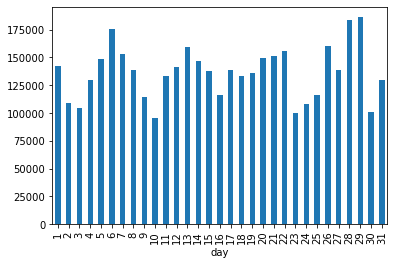

In [11]:
comment_per_day = df.name.groupby(df['day']).count()
comment_per_day.plot(kind='bar')

Overall, there is less traffic during the week end, meaning comments are more likely to be popular if they are posted during the week, especially on wednesday/tuesday/thrusday, because more people are likely to see them and upvote them. There also seems to be more comments posted by the end of the month.

Let's check the repartition between test and train data:

In [12]:
Test_DF = test_split(df)
Train_DF = train_split(df)

In [ ]:
comment_per_day_train = Train_DF.name.groupby(Train_DF['day']).count()
comment_per_day_test = Test_DF.name.groupby(Test_DF['day']).count()

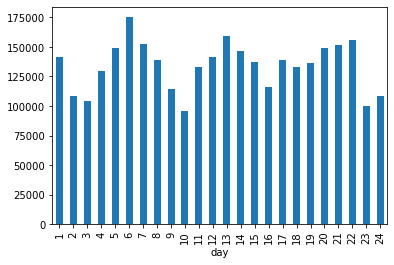

In [13]:
comment_per_day_train.plot(kind='bar')

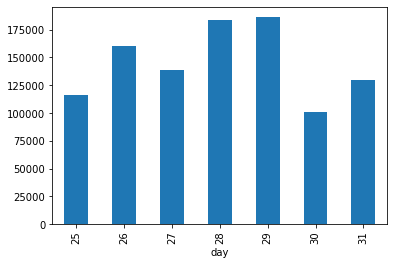

In [15]:
comment_per_day_test.plot(kind='bar')

It seems that the test set is actually the comments from the last week of May 2015, while the train data is the comments from the 3 first weeks. As in the train data we will never observe the values 25 to 31, we need to transform this variable. We transform it to "day of the week". The pattern during the last week of May does seem different though, so it maybe another splitting of this dataset could have been done.

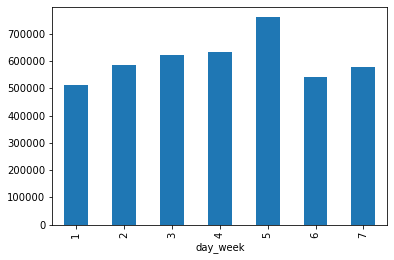

In [16]:
monday = [4,11,18,25]
tuesday = [5,12,19,26]
wednesday = [6,13,20,27]
thursday = [7,14,21,28]
friday = [1,8,15,22,29]
saturday = [2,9,16,23,30]
sunday = [3,10,17,24,31]

df['day_week'] = np.where(df.day.isin(monday),1,
                          np.where(df.day.isin(tuesday),2,
                                   np.where(df.day.isin(wednesday),3,
                                            np.where(df.day.isin(thursday),4,
                                                     np.where(df.day.isin(friday),5,
                                                              np.where(df.day.isin(saturday),6,
                                                                       np.where(df.day.isin(sunday),7,'OK')))))))
df.name.groupby(df.day_week).count().plot(kind='bar')

Friday is the day with the most traffic. There is not so much trafic on the week-end and on monday

In [17]:
df["monday"] = np.where(df["day_week"] == "1", 1, 0)
df["tuesday"] = np.where(df["day_week"] == "2", 1, 0)
df["wednesday"] = np.where(df["day_week"] == "3", 1, 0)
df["thursday"] = np.where(df["day_week"] == "4", 1, 0)
df["friday"] = np.where(df["day_week"] == "5", 1, 0)
df["saturday"] = np.where(df["day_week"] == "6", 1, 0)
df["sunday"] = np.where(df["day_week"] == "7", 1, 0)

df.day_week = df.day_week.astype(str)

Let's do the same analysis on hour of the day. It seems that the hours with the most traffic are from 2PM to 2AM. The traffic drastically slows down during morning and noon.

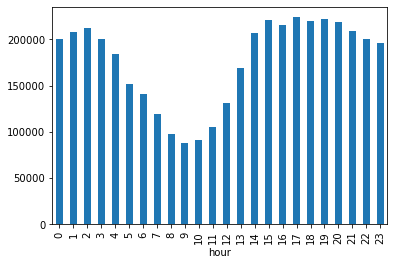

In [18]:
df['hour'] = df["created_utc"].dt.hour
df.name.groupby(df.hour).count().plot(kind='bar')

We drop the unneeded variables :

In [19]:
df = df.drop(["day"], axis=1)

### Network

**The author of the post**

People with high popularity or well-known in the subreddit might better scores. Let's have a look

In [ ]:
print("There are",len(set(df.author)),"unique authors in the subreddit.")

Creation of a data base at the level of the author

In [20]:
 data_agg = df.groupby("author", as_index=False).agg({"ups": ["sum","mean"],
                                                            "body": ["count"],
                                                            "popularity":["sum"]})

We create an active member index such as :


*   active_user = 1 : number of posts > 4, number of popular comments > 1
*   active_user = 2 : number of posts <= 4, number of popular comments > 1
*   active_user = 3 : number of posts > 4, number of popular comments <= 1
*   active_user = 4 : number of posts <= 4, number of popular comments <= 1

This enables us to distinguish the popular and active users (post a lot, get a lot upvotes), the popular but not so active users (post averagly, get lots of upvotes), the not popular but active user, and the not popular and not active user.

The thresholds that are used here are the 3rd quantiles at the user level.





In [21]:
data_agg["active_user"] = np.where(data_agg.popularity["sum"] > 1,
                                   np.where(data_agg.body["count"] > 5, 1, 2),
                                   np.where(data_agg.body["count"] > 5, 3, 4))
data_agg["active_user"].value_counts()/len(data_agg["active_user"])*100

4    47.129403
2    31.118120
1    19.466302
3     2.286175
Name: active_user, dtype: float64

In [22]:
data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns.values]
data_agg.describe()

,ups_sum,ups_mean,body_count,popularity_sum,active_user_
count,5.707350e+05,471565.000000,570735.000000,5.707350e+05,570735.000000
mean,7.184664e+01,12.268588,7.420097,1.775865e+02,2.770787
std,1.613216e+03,91.238355,417.002033,8.343958e+03,1.228247
min,-1.752000e+03,-104.000000,0.000000,0.000000e+00,1.000000
25%,1.000000e+00,1.000000,1.000000,0.000000e+00,2.000000
50%,2.000000e+00,1.500000,2.000000,2.000000e+00,2.000000
75%,1.000000e+01,3.263158,5.000000,1.000000e+02,4.000000
max,1.144053e+06,5403.000000,312007.000000,6.220793e+06,4.000000


In [23]:
data_agg.groupby("active_user_").agg({"ups_sum": ["sum","mean","median","min","max"],"body_count": ["sum","mean","median","min","max"],
                                       "popularity_sum":["sum","mean","median","min","max"]})

ups_sum                                       body_count  \
                     sum        mean median     min        max        sum   
active_user_                                                                
1             33194788.0  298.780281   33.0 -1752.0  1144053.0    3291096   
2              3766335.0   21.206602    0.0  -122.0     8912.0     398002   
3               451127.0   34.574418   11.0  -409.0     5568.0     117942   
4              3593143.0   13.358203    2.0  -165.0     5669.0     427869   

                                           popularity_sum                     \
                   mean median min     max            sum        mean median   
active_user_                                                                   
1             29.622560     13   6  312007       79168920  712.585125    298   
2              2.240977      2   0       5       22107920  124.480130     99   
3              9.039086      7   6     161           7091    0.543455      1   
4              1.590686      1   0       5          70908    0.263614      0   

                           
             min      max  
active_user_               
1              2  6220793  
2              2      495  
3              0        1  
4              0        1

We can see a real difference of score and number of comment posted between the four groups
This is basically like finding the active members of the subreddit.

Now we mark the active users in the train database.

In [24]:
classification_active_user =  data_agg[['author_', 'active_user_','ups_mean']].copy()
classification_active_user.rename(columns={'author_': 'author'}, inplace=True)

In [25]:
df = pd.merge(df,classification_active_user,on='author',how='outer')
df.head()

,created_utc,ups,link_id,name,id,author,body,parent_id,popularity,day_week,monday,tuesday,wednesday,thursday,friday,saturday,sunday,hour,active_user_,ups_mean
0,2015-05-01 00:00:00,3.0,t3_34f9rh,t1_cqug90j,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr,1,5,0,0,0,0,1,0,0,0,1,18.702703
1,2015-05-01 00:05:40,1.0,t3_34f9rh,t1_cqugg3k,cqugg3k,jesse9o3,Of the 26th letter of the Alphabet,t1_cquga1h,0,5,0,0,0,0,1,0,0,0,1,18.702703
2,2015-05-01 00:25:57,2.0,t3_34f9rh,t1_cquh7b2,cquh7b2,jesse9o3,Pretty much every country in North/South Ameri...,t1_cqugq6h,0,5,0,0,0,0,1,0,0,0,1,18.702703
3,2015-05-01 00:29:54,1.0,t3_34f9rh,t1_cquhclb,cquhclb,jesse9o3,"People that don't wear socks here are odd, mos...",t1_cqugmda,0,5,0,0,0,0,1,0,0,0,1,18.702703
4,2015-05-01 13:54:02,1.0,t3_34f9rh,t1_cquzkrz,cquzkrz,jesse9o3,"A stone is just 14 pounds, and even then it's ...",t1_cquohq1,0,5,0,0,0,0,1,0,0,13,1,18.702703


In [26]:
df["active_user1"] = np.where(df["active_user_"] == 1, 1, 0)
df["active_user2"] = np.where(df["active_user_"] == 2, 1, 0)
df["active_user3"] = np.where(df["active_user_"] == 3, 1, 0)
df["active_user4"] = np.where(df["active_user_"] == 4, 1, 0)

df = df.drop(["active_user_"], axis=1)

In [27]:
df['ups_mean'] = df['ups_mean'].fillna(0)

**Find the parent commentary**

Each comment has a parent (parent_id). Its parent is either another comment or a link. Thus if parent_id = link_id, this means that the comment is related to the link.
It is important to note that you do not have any information about the link itself in the dataset.

According to reddit API: t1 is a comment, t3 is a link

Variables que j'aimerais intégrer:
*   Score du parent
*   Classification de l'auteur du parent
*   Temps depuis que le parent a été posté
*   Élément de liste

All rows are comment but not all parent are comment, some are links. There are 1 284 797 observations linked to a link, on which we have no information. When an observation is linked to a link, we sistematically have parent_id = link_id

link_id is the submission. parent_id is the parent of the comment. It could be another comment or it could be the submission if the comment is a top level comment.

Links start with t3_, comments start with t1_. So yeah, link_id will always start with t3_. If the parent_id starts with t3_, or if it matches the link_id, then you know it's a top level comment.
For each link, there can be several top comments

In [ ]:
print(df.name.astype(str).str[0:2].value_counts())
print(df.parent_id.astype(str).str[0:2].value_counts())
print(df.link_id.astype(str).str[0:2].value_counts())

In [28]:
df[df.link_id == df.parent_id].shape

(1702209, 23)

First of all, we indicate top comments:

In [29]:
df["top_comment"] = np.where(df.parent_id.astype(str).str[0:2] == "t3", 1, 0)
df["top_comment"].value_counts()

0    2532761
1    1702209
Name: top_comment, dtype: int64

**Create hierarchie through comment**

In [30]:
df["rank_comment"] = 0
comment_to_keep = list(set(df.name[df.top_comment == 1]))
for i in range(1,500):
    if i == 1:
        df["rank_comment"] = np.where(df.name.isin(comment_to_keep), 1, df["rank_comment"])
    else:
        df["rank_comment"] = np.where(df.parent_id.isin(comment_to_keep), i, df["rank_comment"])
        comment_to_keep = list(set(df.name[df["rank_comment"] == i]))

In [ ]:
df.ups.groupby(df.rank_comment[df["rank_comment"] < 10]).count().plot(kind='bar')

There is still observations with rank not attributed (=0)

Most of these observations have been posted on the first of the month. Therefore, I assume that these comments are responses to comments that were posted in April 2015 or before and that we do not observe. 

I automatically mark these observations with rank 2 and redo this analysis

In [31]:
general_parent = list(set(df.name))
second_comment = list(set(df.name[(df.rank_comment == 0) &(df.parent_id.isin(general_parent) == False)]))
df["rank_comment"] = np.where(df.name.isin(second_comment), 2, df["rank_comment"])
df["parent_comment_missing"] = np.where(df.name.isin(second_comment), 1, 0)

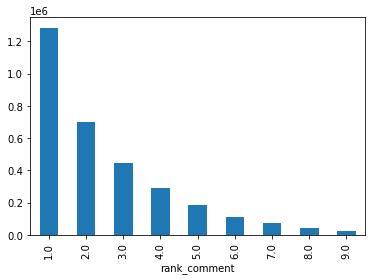

In [33]:
comment_to_keep = list(set(df.name[df.top_comment == 1]))
for i in range(1,500):
    if i == 1:
        df["rank_comment"] = np.where(df.name.isin(comment_to_keep), 1, df["rank_comment"])
    else:
        df["rank_comment"] = np.where(df.parent_id.isin(comment_to_keep), i, df["rank_comment"])
        comment_to_keep = list(set(df.name[df["rank_comment"] == i]))
    
df.ups.groupby(df.rank_comment[df["rank_comment"] < 10]).count().plot(kind='bar')


Our rank variable is complete !

In [34]:
df.drop(['parent_comment_missing'],axis=1, inplace=True)

**Child id**

We extract the child ID (if it exists) so that the future analysis will be easier 

In [36]:
tree = {}
for parent, child in zip(df.name, df.parent_id):
    tree.setdefault(child, set()).add(parent)

temp = pd.DataFrame(tree.items(), columns=['parent', 'child_id'])

In [37]:
temp.rename(columns={'parent': 'name'}, inplace=True)
df = pd.merge(df,temp,on='name',how='left')

**parent score**

We extract the score of the parent comment, which may be important as this will attract attention to the child comment.

In [38]:
tree = {}
for child, parent, score in zip(df.child_id, df.name, df.ups):
    tree.setdefault(parent, score)

In [39]:
temp = pd.DataFrame(tree.items(), columns=['parent', 'score'])

In [40]:
temp.rename(columns={'parent': 'parent_id'}, inplace=True)
temp.rename(columns={'score': 'parent_ups'}, inplace=True)
df = pd.merge(df,temp,on='parent_id',how='left')

**Date parent**

We extract the date at which the parent comment was posted.

In [42]:
tree = {}
for child, parent, date in zip(df.child_id, df.name, df.created_utc):
    tree.setdefault(parent, date)
temp = pd.DataFrame(tree.items(), columns=['parent', 'parent_utc'])
temp.rename(columns={'parent': 'parent_id'}, inplace=True)
df = pd.merge(df,temp,on='parent_id',how='left')

**Time span since parent**

Comments seems to get more upvotes when they are posted shortly after their parent comment. Hence, we create a new variable that contains the time in seconds between a comment and its parent comment. 

In [43]:
df['seconds_after_parent'] = (df.created_utc - df.parent_utc).astype('timedelta64[s]')
df['seconds_after_parent'] = np.where(pd.isna(df['seconds_after_parent']),df['seconds_after_parent'].mean(skipna=True) ,df['seconds_after_parent'])

In [44]:
df.groupby("popularity").agg({"seconds_after_parent":["mean","median","min","max"]})

seconds_after_parent                              
                           mean        median  min        max
popularity                                                   
0                  18094.663352  16700.999304  0.0  1986331.0
1                  11212.991819  10908.000000  2.0  1790037.0
99                 17199.896049  16700.999304  2.0  2556094.0

**Segmentation parent & mean ups parent**

We extract the segmentation of the author who posted the parent comment, but also their average score:

In [45]:
seg1 = {}
for child, parent, seg in zip(df.child_id, df.name, df.active_user1):
    seg1.setdefault(parent, seg)
temp = pd.DataFrame(seg1.items(), columns=['parent_id', 'parent_seg1'])

df = pd.merge(df,temp,on='parent_id',how='left')

seg2 = {}
for child, parent, seg in zip(df.child_id, df.name, df.active_user2):
    seg2.setdefault(parent, seg)
temp = pd.DataFrame(seg2.items(), columns=['parent_id', 'parent_seg2'])

df = pd.merge(df,temp,on='parent_id',how='left')

seg3 = {}
for child, parent, seg in zip(df.child_id, df.name, df.active_user3):
    seg3.setdefault(parent, seg)
temp = pd.DataFrame(seg3.items(), columns=['parent_id', 'parent_seg3'])

df = pd.merge(df,temp,on='parent_id',how='left')

seg4 = {}
for child, parent, seg in zip(df.child_id, df.name, df.active_user4):
    seg4.setdefault(parent, seg)
temp = pd.DataFrame(seg4.items(), columns=['parent_id', 'parent_seg4'])

df = pd.merge(df,temp,on='parent_id',how='left')

In [46]:
mean_ups = {}
for child, parent, mean in zip(df.child_id, df.name, df.ups_mean):
    mean_ups.setdefault(parent, mean)
temp = pd.DataFrame(mean_ups.items(), columns=['parent_id', 'parent_ups_mean'])

df = pd.merge(df,temp,on='parent_id',how='left')


Fill the NA with zeros:

In [47]:
df[df.columns.difference(['ups'])] = df[df.columns.difference(['ups'])].fillna(0)

### Export the cleaned dataset

In [48]:
df = df.drop(["child_id","created_utc","parent_utc"],axis = 1)

In [49]:
file=open(repsource+"df_inter","wb")
pickle.dump(df,file)
file.close()